# Predicting the quality of wine based on its chemical make-up.
### Introduction:
The taste of a wine is affected by its chemical properties/composition (i.e. pH, alcohol content, sugar content, etc.). We wish to predict the quality of a wine given its chemical composition. Although "quality" of wine is a rather abstract and subjective metric, there are trends in the chemical composition of wines which are correlated with its perceived quality. This allows us to predict its quality based on its chemical composition. In order to accomplish this, we are will be using [this data set](https://www.kaggle.com/datasets/yasserh/wine-quality-dataset/) based on data collected from Portuguese "Vinho Verde" wine to assess these factors. There are 11 chemical properties of the wine which are recorded in this data set. The measured quality of the wine is a categorical variable labeled 1-10.

Research question: How can wine quality be predicted using its chemical composition?

### Methods & Results
For this project we will be using classification (*K* nearest neighbors algorithm) to predict the quality of a given wine. We will be using the “quality” variable (categories labeled 1-10) as a label. Features of the wine which have been previously found by [Hu, Gongzhu, et al.](https://ieeexplore.ieee.org/abstract/document/7475021) to be most relevant when classifying wine quality includes volatile acidity (column name: volatile_acidity), free sulfur dioxide value (column name: free_sulfur_dioxide), and alcohol content (column name: alcohol) will be used as predictor variables. The data will be split into training and testing sets so that cross-validation can be performed on the data. Using the data collected from cross-validation, we can graph *K* against the accuracy of that *K*. The best *K* will then be used when classifying the test set. 

We begin by loading the pre-requisite libraries containing the tools we will need for our data analysis.

In [1]:
# Install janitor package and load libraries
install.packages("janitor")
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)
library(janitor)

also installing the dependency ‘snakecase’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks st

The raw data was uploaded to GitHub, which is then loaded into Jupyter and read using the `read_delim` function. `read_delim` was used since the delimiter for our data set was was semi-colon. The quality variable originally contained originally doubles, we wished to use it as a categorical variable so we converted it to factors using the `mutate` and `as_factor` functions. `clean_names` from the `janitor` library was used to make all the variable names lowercase and replaced spaces with underscores since the original variable names contained spaces and quotation marks. The data is already in tidy format.

In [2]:
# Read data
# Change quality from double type to factor type
# Clean the names to be in small letters using _ in the place of space
wine_data <- read_delim("https://raw.githubusercontent.com/rahim620/DSCI100-PROJECT-FALL23/main/data/winequality-red.csv", delim = ";") |>
    mutate(quality = as_factor(quality)) |>
    clean_names()
head(wine_data)

Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,p_h,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


We split the data set into training and testing data sets where 75% of the raw data is used in the training set. Due to the use of randomness of the `initial_split` function, we set a seed to ensure reproducibility.

In [3]:
# Set seed
set.seed(100)
# Split the wine data in training set and testing set
wine_split <- initial_split(wine_data, prop = 0.75, strata = quality)
wine_train <- training(wine_split)
wine_test <- testing(wine_split)

Exploratory data analysis is conducted on the training data by creating a table with the count of wines in each quality class. The mean values of the numerical variables we are interested in, volatile acidity, free sulfur dioxide value, and alcohol content, are shown for each quality class. This is accomplished using the `group_by` function to group the observations by quality class, and then using the `mean` function to calculate the mean values of each variable within each quality class. The count of the number of observations in each quality class is collected using the `n` function.

In [4]:
# Summarize the data
wine_summary <- wine_train |>
    group_by(quality) |>
    summarize(mean_alc = mean(alcohol, na.rm = TRUE), 
              mean_free_so2 = mean(free_sulfur_dioxide, na.rm = TRUE), 
              mean_volatile_acidity = mean(volatile_acidity, na.rm = TRUE), 
              observations = n())
wine_summary

quality,mean_alc,mean_free_so2,mean_volatile_acidity,observations
<fct>,<dbl>,<dbl>,<dbl>,<int>
3,9.955000,11.000000,0.8845000,10
4,10.288750,12.750000,0.7046250,40
5,9.875737,16.565815,0.5817976,509
6,10.617537,15.651357,0.4979749,479
7,11.463379,13.309524,0.4048299,147
8,11.746154,9.923077,0.3792308,13


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


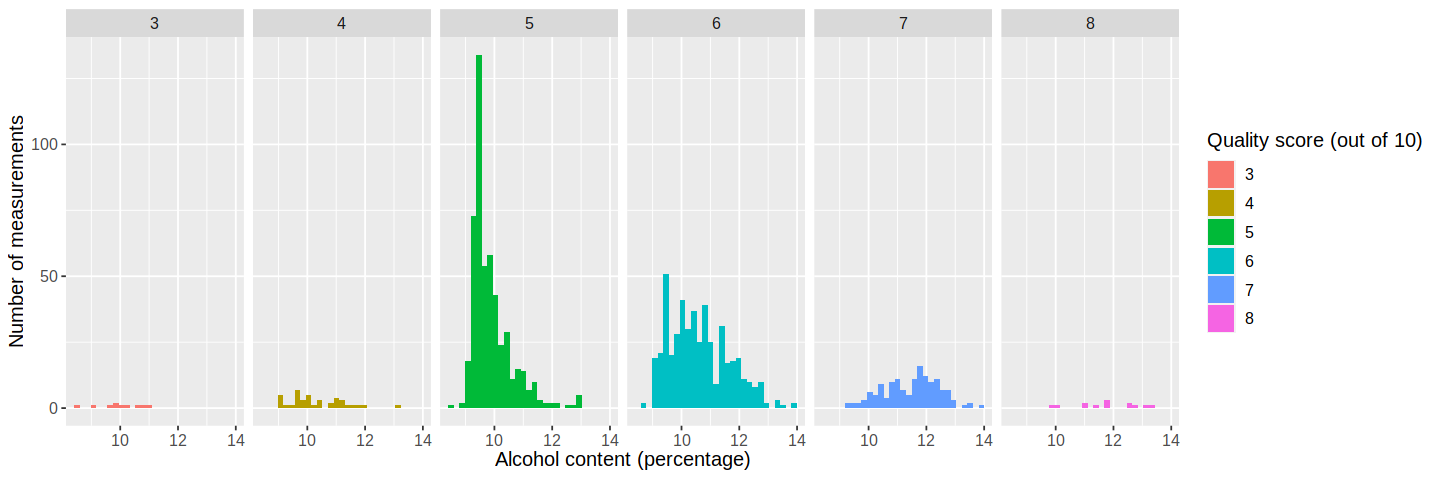

In [5]:
# Histogram to show alcohol measurement distribution
options(repr.plot.width = 12, repr.plot.height = 4)
alcohol_plot <- ggplot(wine_train, aes(x = alcohol, fill = quality)) +
    geom_histogram() +
    facet_grid(cols = vars(quality)) +
    xlab("Alcohol content (percentage)") +
    ylab("Number of measurements") +
    labs(fill = "Quality score (out of 10)") +
    theme(text = element_text(size = 12))
alcohol_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


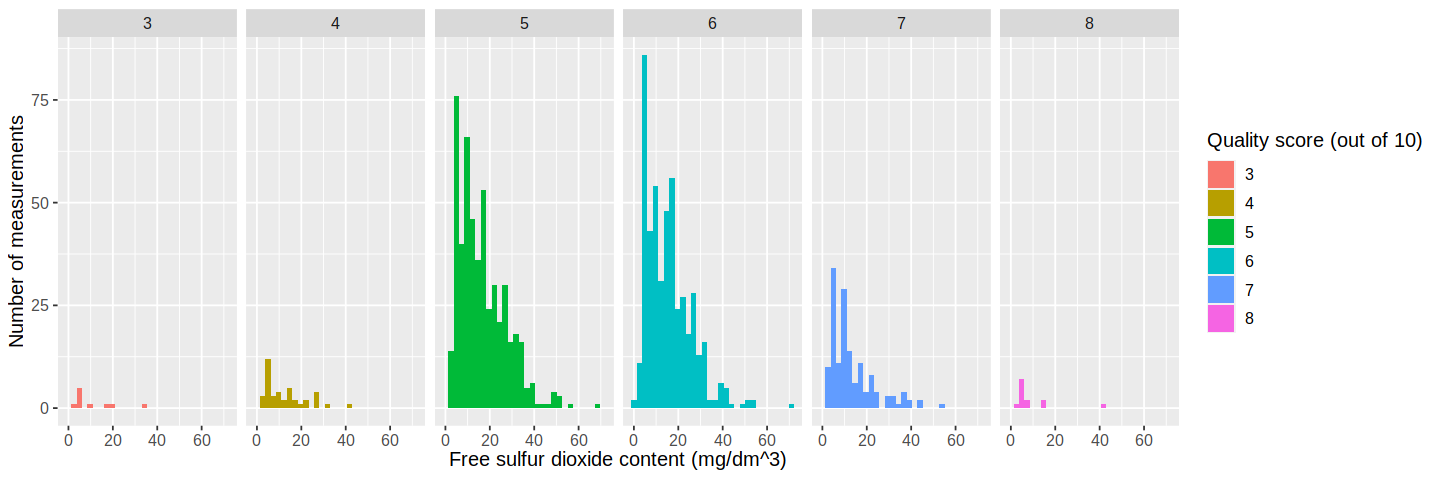

In [6]:
# Histogram to show free sulfur dioxide measurement distribution
options(repr.plot.width = 12, repr.plot.height = 4)
alcohol_plot <- ggplot(wine_train, aes(x = free_sulfur_dioxide, fill = quality)) +
    geom_histogram() +
    facet_grid(cols = vars(quality)) +
    xlab("Free sulfur dioxide content (mg/dm^3)") +
    ylab("Number of measurements") +
    labs(fill = "Quality score (out of 10)") +
    theme(text = element_text(size = 12))
alcohol_plot

List of 1
 $ text:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 12
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


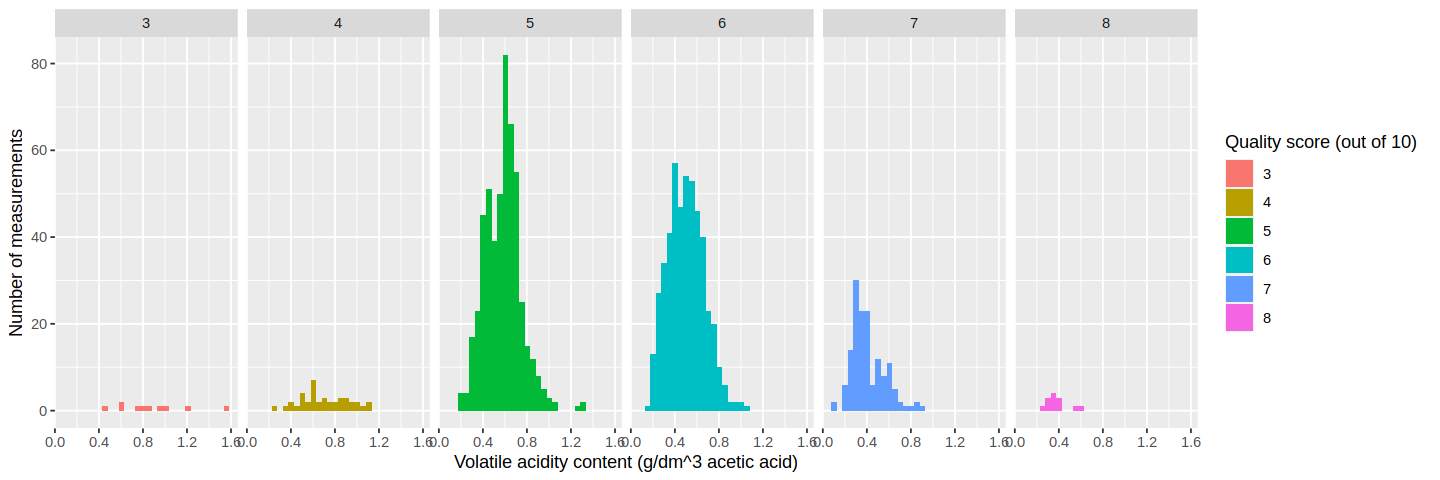

In [7]:
# Histogram to show volatile_acidity measurement distribution
options(repr.plot.width = 12, repr.plot.height = 4)
alcohol_plot <- ggplot(wine_train, aes(x = volatile_acidity, fill = quality)) +
    geom_histogram() +
    facet_grid(cols = vars(quality)) +
    xlab("Volatile acidity content (g/dm^3 acetic acid)") +
    ylab("Number of measurements") +
    labs(fill = "Quality score (out of 10)")
    theme(text = element_text(size = 12))
alcohol_plot

### Expected outcomes and significance:
We expect to accurately predict the quality of wine based on the volatile acidity, free sulfur dioxide value, and alcohol content of the wine. The classification algorithm could help winemakers understand the qualities they should prioritize or selectively specialize in to increase the quality of their wine. Similarly, the classification algorithm could help an avid Oenophile/Consumer make a more informed decision when purchasing expensive Wine. The data we plan on using is based in Portugal. Further questions such as the difference in the importance of different traits in the classification of wine quality in other parts of the world could provide useful information and lead to new relationships. A more specific question could be whether the species/region where the grapes used to make the wine are foraged lead to differences in quality.